In [1]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
#######adapted for eager execution and TensorFlow 2.0.0 alpha ######

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

In [3]:
n_classes = 2
hidden_units = [500,100]
learning_rate  = 1e-4
steps = 1000
optimiser = tf.compat.v1.train.AdagradOptimizer(learning_rate = learning_rate)

In [4]:
# Load all files from a directory into a DataFrame.
def load_data(directory):
    directory_data = {}
    directory_data["description"] = []
    directory_data["sentiment"] = []
    for file in os.listdir(directory):
        with tf.io.gfile.GFile(os.path.join(directory, file), "r") as f:
            directory_data["description"].append(f.read())
            directory_data["sentiment"].append(re.match("\d+_(\d+)\.txt", file).group(1))
    return pd.DataFrame.from_dict(directory_data)

In [5]:
# Merge positive and negative examples, add a polarity column and shuffle.
def load(directory):
    positive_df = load_data(os.path.join(directory, "pos"))
    positive_df["polarity"] = 1

    negative_df = load_data(os.path.join(directory, "neg"))
    negative_df["polarity"] = 0
    return pd.concat([positive_df, negative_df]).sample(frac=1).reset_index(drop=True)

In [6]:
# Download and process the dataset files.
def acquire_data():
    data = tf.keras.utils.get_file(
    fname="aclImdb.tar.gz",
    origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", extract=True)

    train_df = load(os.path.join(os.path.dirname(data), "aclImdb", "train"))
    test_df = load(os.path.join(os.path.dirname(data),    "aclImdb", "test"))

    return train_df, test_df


tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # use .INFO for lots of output
#acquire IMDb data
train_df, test_df = acquire_data()

In [7]:
train_df.head()

,description,sentiment,polarity
0,"As far as I can understand, TIW WATCHER is the...",2,0
1,yes i have a copy of it on VHS uncut in great ...,10,1
2,This film is about the unlikely friendship bet...,7,1
3,A very cute movie with a great background prov...,9,1
4,I have seen this film many times and I like al...,9,1


In [8]:
train_df.tail()

,description,sentiment,polarity
24995,"A 1957 (yes, that's the correct date) J. Arthu...",3,0
24996,Such a long awaited movie.. But it has disappo...,1,0
24997,A classic series that should be at least repea...,10,1
24998,I saw this obvious schlock fest on a video sto...,1,0
24999,This film takes place in the 1950s. According ...,8,1


In [9]:
test_df.head()

,description,sentiment,polarity
0,It may interest people to know that this film ...,9,1
1,I saw this movie when it aired on the WB and f...,9,1
2,"Bring a box of Kleenex to this funny, engaging...",9,1
3,"May Contain Spoilers!!! In no way, shape or fo...",7,1
4,one of the worst excuses for an irish accents ...,4,0


In [10]:
test_df.tail()

,description,sentiment,polarity
24995,Didn't really know what to expect from this mo...,7,1
24996,This movie was release when I was 15 and I cou...,7,1
24997,"On a second viewing, this is still a wonderful...",8,1
24998,"Well as you can see, I got to this party quite...",10,1
24999,I saw Riverdance - The New Show and loved it f...,10,1


In [11]:
# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(train_df, train_df["polarity"], num_epochs=None, shuffle=True)

# Prediction on the whole training set.
predict_train_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(train_df, train_df["polarity"], shuffle=False)

# Prediction on the test set.
predict_test_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(test_df, test_df["polarity"], shuffle=False)

In [12]:
embedded_text_feature_column = hub.text_embedding_column(
    key="description",
    module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")

In [13]:

estimator = tf.estimator.DNNClassifier(
    hidden_units = hidden_units,
    feature_columns=[embedded_text_feature_column],
    n_classes=n_classes,
    optimizer= optimiser,
    model_dir = "./tmp/IMDbModel"
, loss_reduction=tf.compat.v1.losses.Reduction.SUM)

In [14]:
estimator.train(input_fn=train_input_fn, steps=steps);

In [15]:

train_result = estimator.evaluate(input_fn=predict_train_input_fn)
test_result = estimator.evaluate(input_fn=predict_test_input_fn)

print("Training set accuracy: {accuracy}".format(**train_result))
print("Test set accuracy: {accuracy}".format(**test_result))

Training set accuracy: 0.7282000184059143
Test set accuracy: 0.7192000150680542


In [16]:
def get_predictions(estimator, input_fn):
    return [prediction["class_ids"][0] for prediction in estimator.predict(input_fn=input_fn)]

Raw figures:
[[9412 3088]
 [3707 8793]]


Text(33.0, 0.5, 'True')

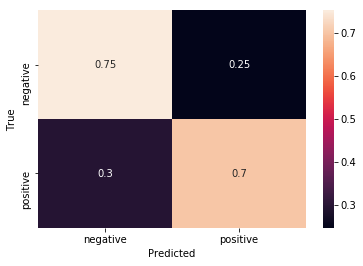

In [17]:
LABELS = ["negative", "positive"]

# Create a confusion matrix on training data.
confusion_train = tf.math.confusion_matrix(labels=train_df["polarity"], predictions=get_predictions(estimator, predict_train_input_fn))
print("Raw figures:")
print(confusion_train.numpy())
# Normalize the confusion matrix so that each row sums to 1.
top = confusion_train.numpy()
bottom = np.sum(top)
confusion_train = 2*top/bottom

sns.heatmap(confusion_train, annot=True, xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel("Predicted")
plt.ylabel("True")

Raw figures:
[[9395 3105]
 [3915 8585]]


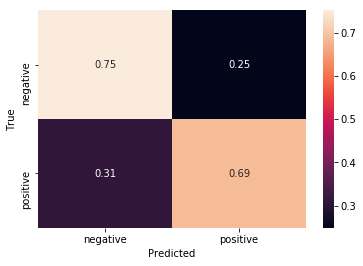

In [18]:
# Create a confusion matrix on test data.
confusion_test = tf.math.confusion_matrix(labels=test_df["polarity"], predictions=get_predictions(estimator, predict_test_input_fn))
print("Raw figures:")
print(confusion_test.numpy())
# Normalize the confusion matrix so that each row sums to 1.
top = confusion_test.numpy()
bottom = np.sum(top)
confusion_test = 2*top/bottom

sns.heatmap(confusion_test, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");